In [1]:
import latentvelo as ltv
import numpy as np
import scanpy as sc
import scvelo as scv
import cellrank as cr
import matplotlib.pyplot as plt

Global seed set to 0


# Read data from cellrank package

In [2]:
adata =  cr.datasets.pancreas()

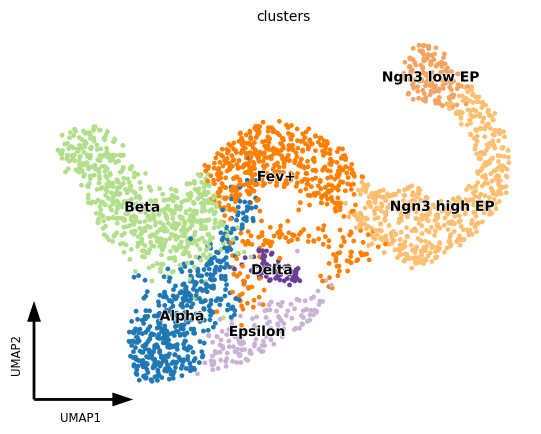

In [3]:
scv.pl.umap(adata, color='clusters', frameon='artist')

# Setup data and train model

In [4]:
scv.pp.filter_genes(adata, min_shared_counts=20)
adata = ltv.utils.anvi_clean_recipe(adata, celltype_key='clusters')

Filtered out 22024 genes that are detected 20 counts (shared).
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
model = ltv.models.AnnotVAE(observed=2000, latent_dim=30, encoder_hidden=35, zr_dim=2, h_dim=3, 
                            celltypes=len(adata.obs.clusters.unique()))

In [6]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 100, learning_rate=1e-2,
                                      epochs=0, name='pancreas_parameters', grad_clip=100)

Warning, folder already exists. This may overwrite a previous fit.
910 velocity genes used
Loading best model at 0 epochs.


In [7]:
import torch as th
model.load_state_dict(th.load('pancreas_parameters_testpathreg/model_state_epoch46.params',map_location=th.device('cuda')))

<All keys matched successfully>

# Refine ODE

Increase the penalty for the loss term comparing the encoded latent states to the latent dynamics. Improves latent trajectories fit to the data.

In [8]:
model = ltv.sde_models.RefineODE(model, observed=2000, latent_dim=30, encoder_hidden=35, zr_dim=2, h_dim=3,
                                 max_sigma_z=0.005, linear_splicing=False)

In [9]:
epochs, val_ae, val_traj = ltv.train(model, adata, batch_size = 300, learning_rate=5e-2, #100
                                      epochs=0, name='refine_pancreas_params', grad_clip=10000,
                                            shuffle=False)

Warning, folder already exists. This may overwrite a previous fit.
910 velocity genes used
Loading best model at 0 epochs.


In [10]:
import torch as th
model.load_state_dict(th.load('refine_pancreas_params_test/model_state_epoch49.params',map_location=th.device('cuda')))

<All keys matched successfully>

# Compute velocities and plot on UMAP

In [11]:
latent_adata, adata = ltv.output_results(model, adata, gene_velocity=True, decoded=True,
                                        num_greater_zero=25)

In [12]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')

computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)


/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)


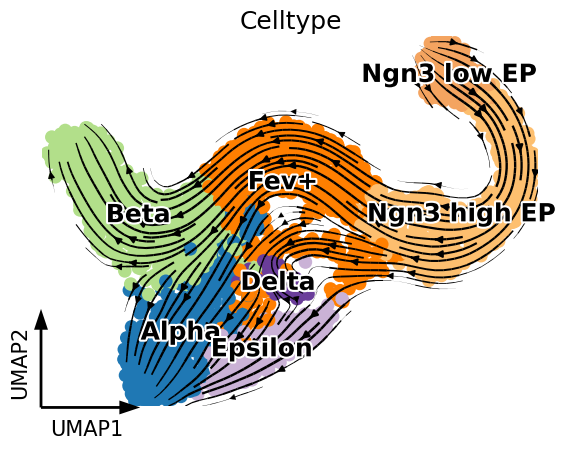

In [13]:
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters'], 
                                 title='Celltype', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist')

saving figure to file figures/pancreas_model_umap.png


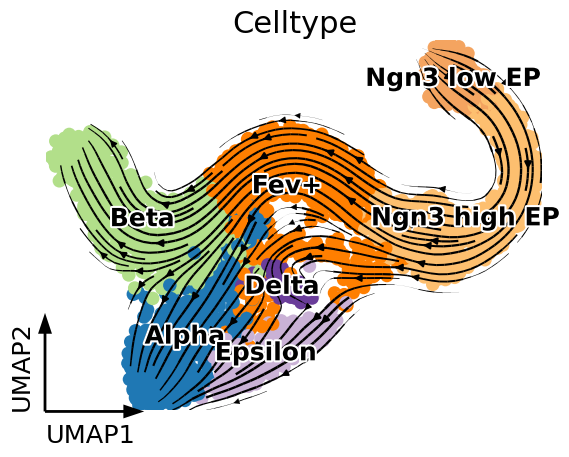

In [13]:
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters'], 
                                 title='Celltype', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=22, frameon='artist',
                                save='figures/pancreas_model_umap.png')

saving figure to file figures/pancreas_model_umap_novelo.png


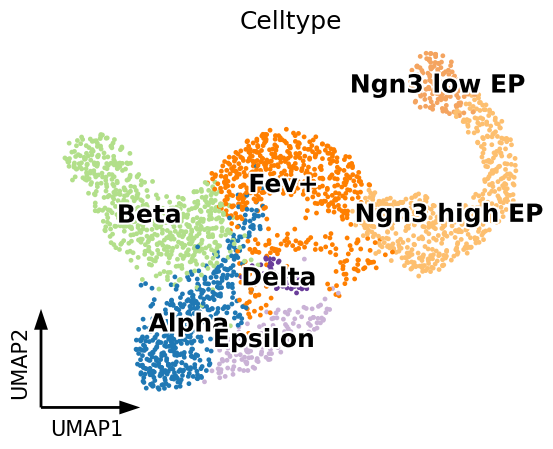

In [14]:
scv.pl.umap(latent_adata, color=['clusters'], 
                                 title='Celltype', alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='figures/pancreas_model_umap_novelo.png')

saving figure to file figures/pancreas_model_umap_latent_time.png


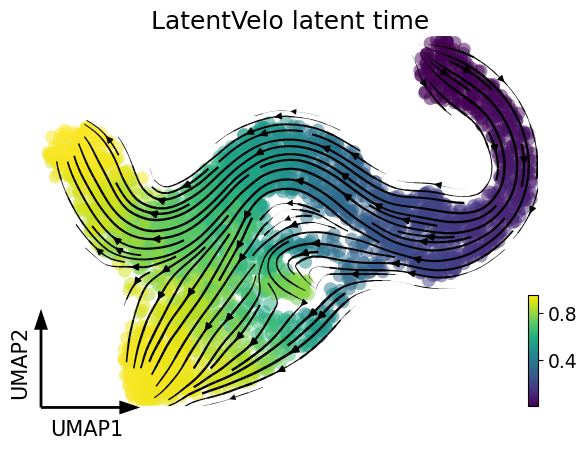

In [15]:
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', color=['latent_time'], 
                                 title='LatentVelo latent time', alpha=0.5, 
                                 fontsize=18, frameon='artist',
                                save='figures/pancreas_model_umap_latent_time.png')

saving figure to file figures/pancreas_model_umap_lineages.png


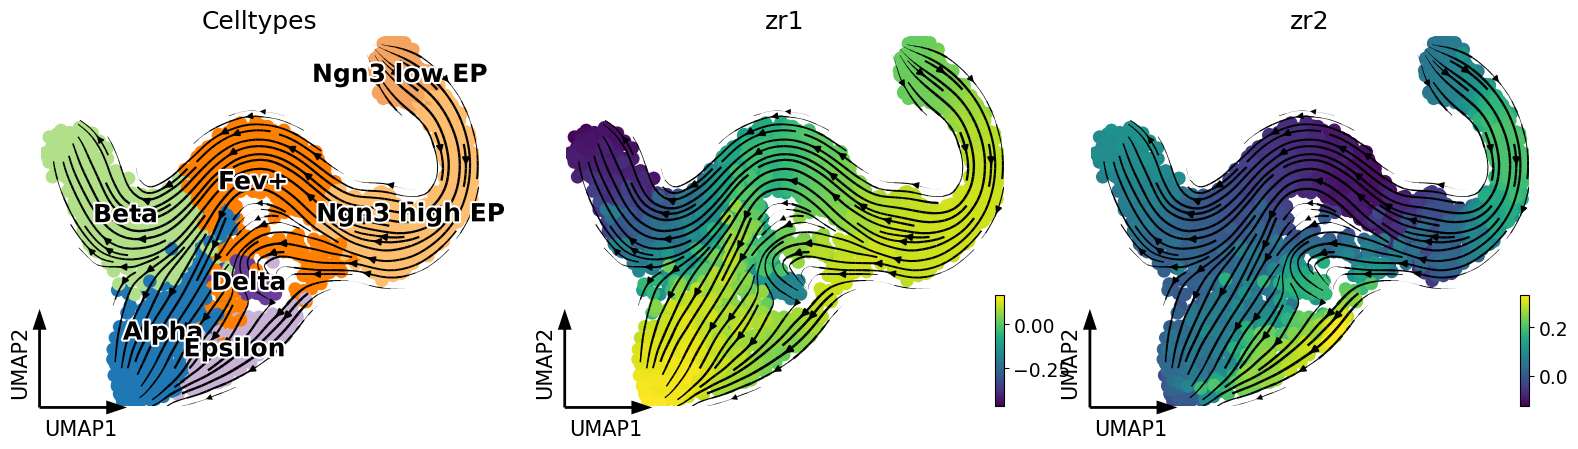

In [16]:
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pl.velocity_embedding_stream(latent_adata,vkey='spliced_velocity', color=['clusters', 'zr1', 'zr2'], 
                                 title=['Celltypes', 'zr1', 'zr2'], alpha=1, 
                                 legend_fontsize=18, legend_fontoutline=3, fontsize=18, frameon='artist',
                                save='figures/pancreas_model_umap_lineages.png')

In [12]:
# save fit
latent_adata.write('../benchmark/real_data/fits/pancreas_latent_adata.h5ad')

# Gene velocities

Select a few genes with high test set R2 scores

In [14]:
adata.var.R2_traj_test[['Cpe', 'Nnat', 'Ppp3ca']]

index
Cpe       0.750635
Nnat      0.944323
Ppp3ca    0.837291
Name: R2_traj_test, dtype: float64

Show gene spliced vs unspliced gene dynamics

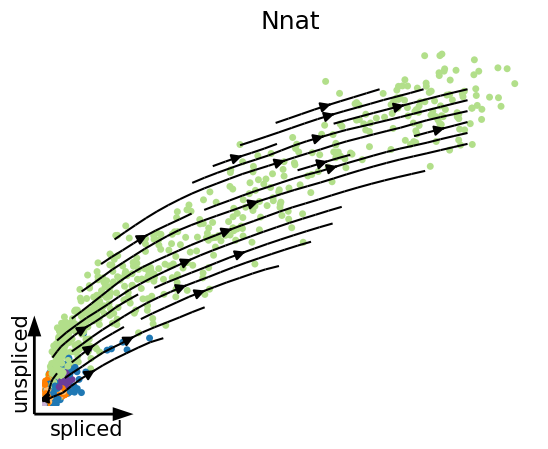

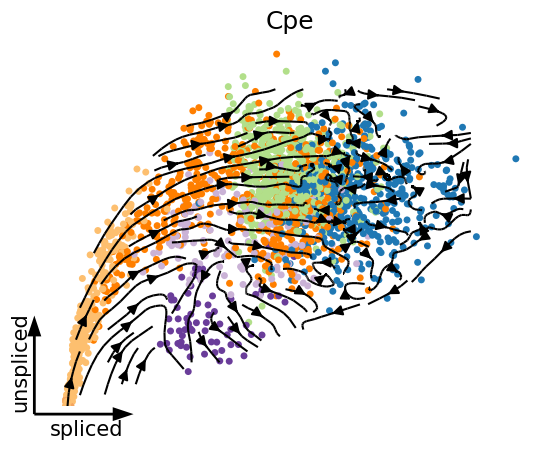

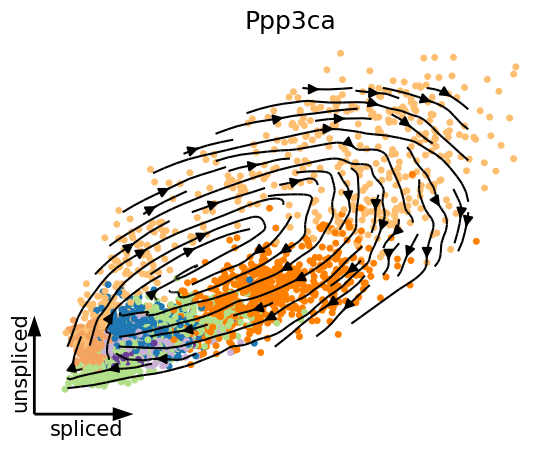

In [15]:
ltv.pl.scatter_stream(adata, 'Nnat', cluster_key='clusters', min_density=0.01)
#plt.savefig('figures/pancreas_nnat.pdf')
plt.show()

ltv.pl.scatter_stream(adata, 'Cpe', cluster_key='clusters', min_density=0.01)
#plt.savefig('figures/pancreas_cpe.pdf')
plt.show()

ltv.pl.scatter_stream(adata, 'Ppp3ca', cluster_key='clusters', min_density=0.01)
#plt.savefig('figures/pancreas_ppp3ca.pdf')
plt.show()

Show value of velocity and latent time vs spliced.

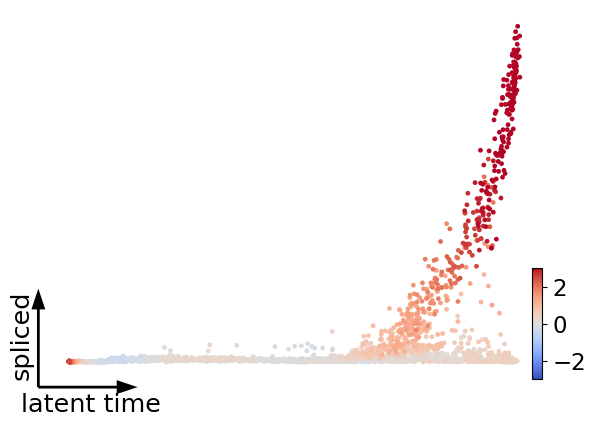

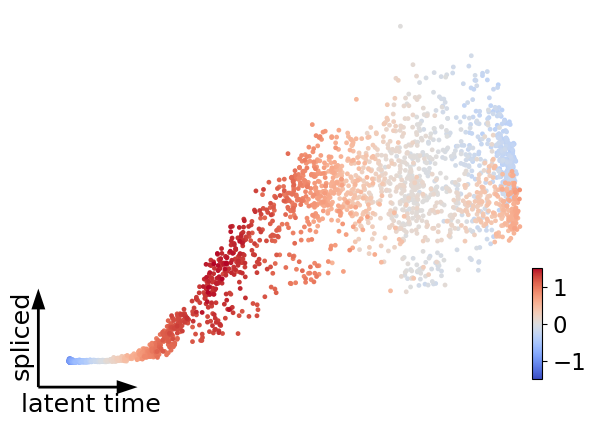

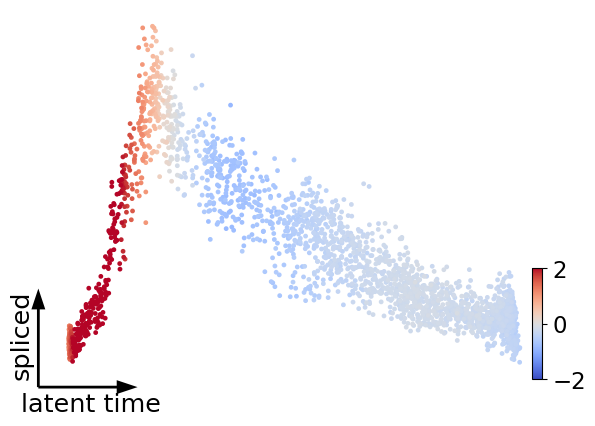

In [16]:
adata.obs['Cpe_direction'] = adata[:,adata.var.index.values=='Cpe'].layers['velo'][:,0]
adata.obs['Ppp3ca_direction'] = adata[:,adata.var.index.values=='Ppp3ca'].layers['velo'][:,0]
adata.obs['Nnat_direction'] = adata[:,adata.var.index.values=='Nnat'].layers['velo'][:,0]

scv.pl.scatter(adata, x='latent_time', y='Nnat', color='Nnat_direction', color_map='coolwarm',
              title='', vmin=-3, vmax=3, frameon='artist',
              fontsize=22)#, save='figures/Nnat_direction_May16.png')

scv.pl.scatter(adata, x='latent_time', y='Cpe', color='Cpe_direction', color_map='coolwarm', 
               title='', vmin=-1.5, vmax=1.5, frameon='artist',
              fontsize=22)#, save='figures/Cpe_direction_May16.png')

scv.pl.scatter(adata, x='latent_time', y='Ppp3ca', color='Ppp3ca_direction', color_map='coolwarm',
               title='', vmin=-2, vmax=2, frameon='artist',
              fontsize=22)#, save='figures/Ppp3ca_direction_May16.png')

# Compute CBDir transition scores

In [17]:
pancreas_edges = [
    ('Ngn3 low EP', 'Ngn3 high EP'), 
    ('Ngn3 high EP', 'Fev+'),
    ('Fev+', 'Delta'), 
    ('Fev+', 'Beta'), ('Fev+','Epsilon'), ('Fev+','Alpha')]

In [18]:
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='pca')
pancreas_pca = ltv.ev.cross_boundary_correctness(latent_adata,
                                  'clusters', 'spliced_velocity_pca', pancreas_edges, x_emb='X_pca', 
                                                  majority_vote=True, return_raw=True)

computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_pca', embedded velocity vectors (adata.obsm)


/home/spencer/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


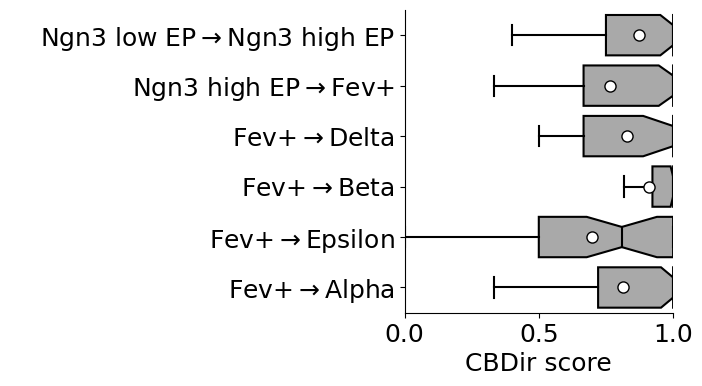

In [19]:
ax=ltv.pl.transition_scores(pancreas_pca, raw=True)
ax.set(xlim=(0,1))
#plt.savefig('../figures/pancreas_transitions.pdf')
plt.show()

# Plot z_r scatter and compute lineage classification accuracy from z_r

Renamed 'zr' to convention 'X_zr' (adata.obsm).
saving figure to file figures/pancreas_zr_plot.png


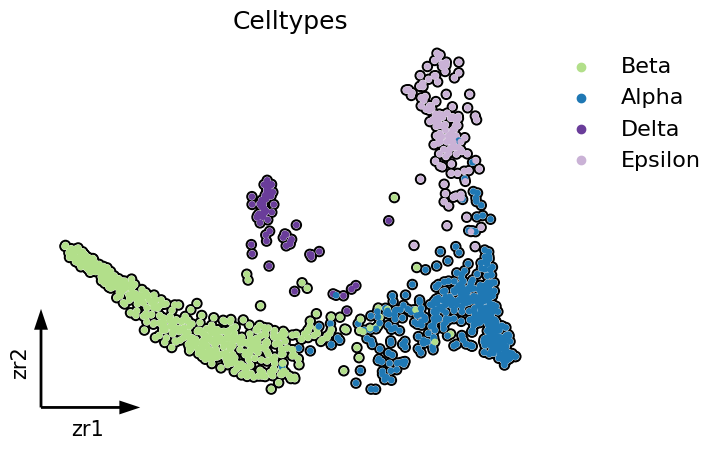

In [29]:
scv.pl.scatter(latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])],
               'zr', color='clusters', frameon='artist', title='Celltypes', fontsize=18,
              legend_fontsize=16, add_outline=True, save='figures/pancreas_zr_plot.png')

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

clf = LogisticRegression(penalty='none', max_iter=1e4)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Epsilon', 'Alpha', 'Beta', 'Delta'])].copy()


X = data_.obsm['zr']
y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


pancreas_cvs = cross_val_score(clf, X, y, cv=25)

In [21]:
print('Prediction accuracy (2.5, 50, 97.5) percentiles:', np.percentile(pancreas_cvs, q=[2.5,50,97.5]))

Prediction accuracy (2.5, 50, 97.5) percentiles: [0.91764706 0.96078431 1.        ]


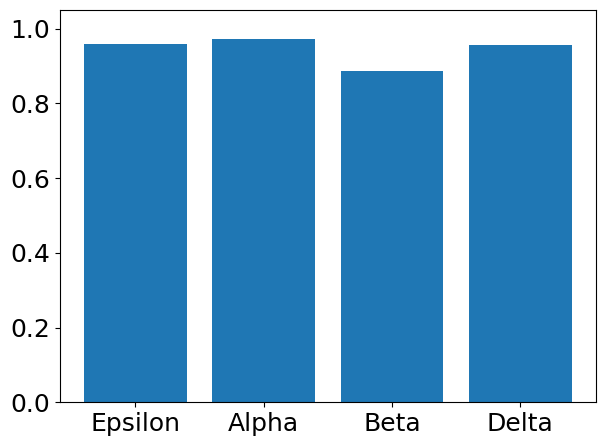

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
clf.fit(X, y)
pred = clf.predict(X)
class_accuracy = confusion_matrix(y, pred, normalize="true").diagonal()

fig, ax = plt.subplots()

plt.bar(x=['Epsilon', 'Alpha', 'Beta', 'Delta'],height=class_accuracy)

ax.set(ylim=(0,1.05))
#ax.set(ylabel='Classification accuracy')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
celltype = label_encoder.fit_transform(latent_adata.obs['clusters'])
latent_adata.obs['celltype_id'] = celltype

In [24]:
colors = []
for i in range(latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].shape[0]):
    if latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].obs.clusters[i] == 'Beta':
        colors.append('#b2df8a')
    elif latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].obs.clusters[i] == 'Alpha':
        colors.append('#1f78b4')
    elif latent_adata[latent_adata.obs.clusters.isin(['Alpha', 'Beta', 'Delta', 'Epsilon'])].obs['clusters'][i] == 'Delta':
        colors.append('#6a3d9a')
    else:
        colors.append('#cab2d6')

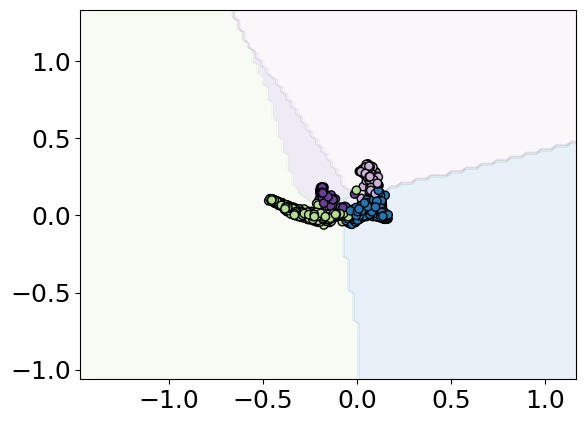

In [25]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=50)

data_= latent_adata[latent_adata.obs['clusters'].isin(['Epsilon', 'Alpha', 'Beta', 'Delta'])].copy()


X = data_.obsm['zr']

y = LabelEncoder().fit_transform(data_.obs['clusters'].values)


clf.fit(X, y)

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])

disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,
)
disp.ax_.scatter(X[:, 0], X[:, 1], edgecolor="k", 
                c = colors)
plt.show()

# Latent trajectories

In [26]:
z_traj, times = ltv.cell_trajectories(model, adata)

In [27]:
alpha_cells = np.where(latent_adata.obs.clusters=='Alpha')[0]
beta_cells = np.where(latent_adata.obs.clusters=='Beta')[0]
delta_cells = np.where(latent_adata.obs.clusters=='Delta')[0]
epsilon_cells = np.where(latent_adata.obs.clusters=='Epsilon')[0]

In [28]:
with th.no_grad():
    xhat_delta  = ltv.tl.cell_trajectories(z_traj[delta_cells], times[delta_cells], latent_adata, adata, beta_cells, 0.3)
    xhat_beta = ltv.tl.cell_trajectories(z_traj[beta_cells], times[beta_cells], latent_adata,adata, beta_cells, 0.3)
    xhat_alpha = ltv.tl.cell_trajectories(z_traj[alpha_cells], times[alpha_cells], latent_adata, adata, alpha_cells, 0.3)
    xhat_epsilon = ltv.tl.cell_trajectories(z_traj[epsilon_cells], times[epsilon_cells], latent_adata, adata, epsilon_cells, 0.3)

In [29]:
import pandas as pd

delta_df = pd.DataFrame(xhat_delta, columns=adata.var.index.values)
delta_df['clusters'] = 'Delta'

beta_df = pd.DataFrame(xhat_beta, columns=adata.var.index.values)
beta_df['clusters'] = 'Beta'

alpha_df = pd.DataFrame(xhat_alpha, columns=adata.var.index.values)
alpha_df['clusters'] = 'Alpha'

epsilon_df = pd.DataFrame(xhat_epsilon, columns=adata.var.index.values)
epsilon_df['clusters'] = 'Epsilon'

df = pd.concat([delta_df, beta_df, alpha_df, epsilon_df])

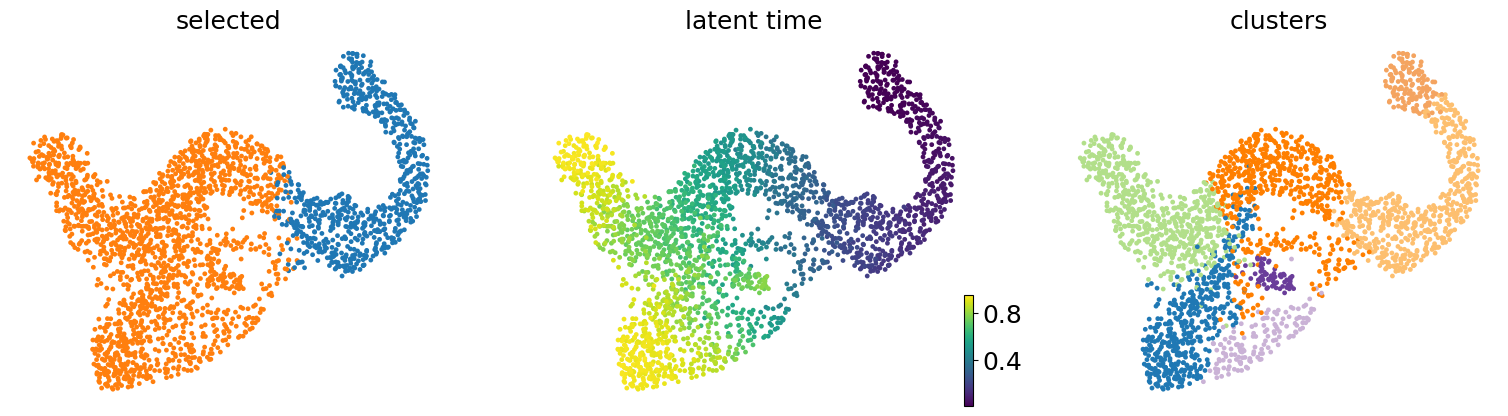

In [30]:
adata.obs['selected'] = 0
adata.obs['selected'][adata.obs.latent_time > 0.3] = 1
scv.pl.umap(adata, color=['selected', 'latent_time', 'clusters'])

In [32]:
beta_de = ltv.tl.de_genes(adata, df, 'Beta', celltype_key='clusters', mode='greater')
beta_de['statistic'] = -1*np.abs(beta_de['statistic'])
beta_de = beta_de.sort_values('statistic')

In [33]:
beta_de_genes = list(beta_de[beta_de['pval'] < 1e-5][:500]['gene'].values)

In [34]:
import gseapy

enr_res = gseapy.enrichr(gene_list=beta_de_genes,
                     organism='mouse', 
                    background=list(adata.var.index.values), 
                     gene_sets=['GO_Biological_Process_2021'])

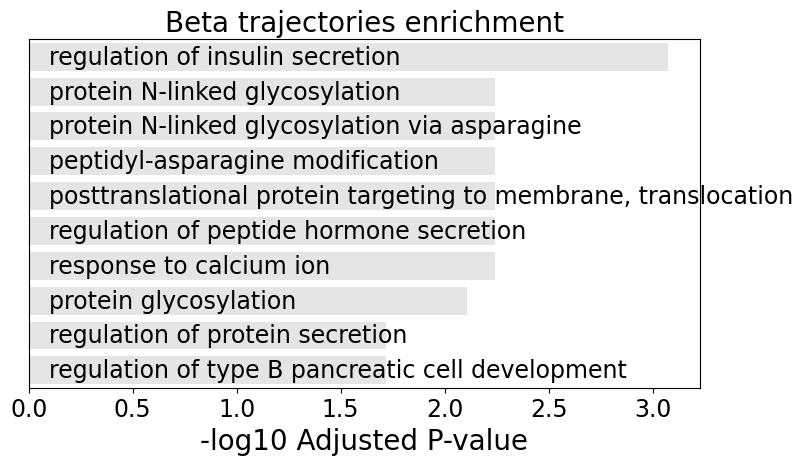

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,ax=plt.subplots(figsize=(8.5,5))

enr_res.results.Term = enr_res.results.Term.str.split(" \(GO").str[0]

results_df = enr_res.results
results_df = results_df[results_df['Adjusted P-value'] < 0.05]
results_df['-log10 Adjusted P-value'] = -1*np.log10(results_df['Adjusted P-value'])

ax=sns.barplot(data = results_df[:10], x='-log10 Adjusted P-value', y='Term', color='grey',
              alpha=0.2)

ax.set_yticks([])
ax.set_yticklabels([]) 
ax.set_ylabel('')
ax.set_xlabel('-log10 Adjusted P-value', fontsize=20)
ax.tick_params(labelsize=17)

plt.title('Beta trajectories enrichment', fontsize=20)

for i, yi in enumerate(np.arange(min(results_df.shape[0],10))):
    ax.text(0.1, yi, results_df['Term'][i], horizontalalignment='left', 
            verticalalignment='center', fontsize=17)

plt.tight_layout()
#plt.savefig('figures/Beta_trajectories_GO.pdf')
plt.show()

Compute UMAP on latent space

In [36]:
from umap import UMAP
from sklearn.preprocessing import LabelEncoder
umap = UMAP(n_components=2, min_dist=1, random_state=11).fit(latent_adata.X)

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity graph (using 1/16 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

/home/spencer/.local/lib/python3.8/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:00) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'spliced_velocity_umap_latent', embedded velocity vectors (adata.obsm)


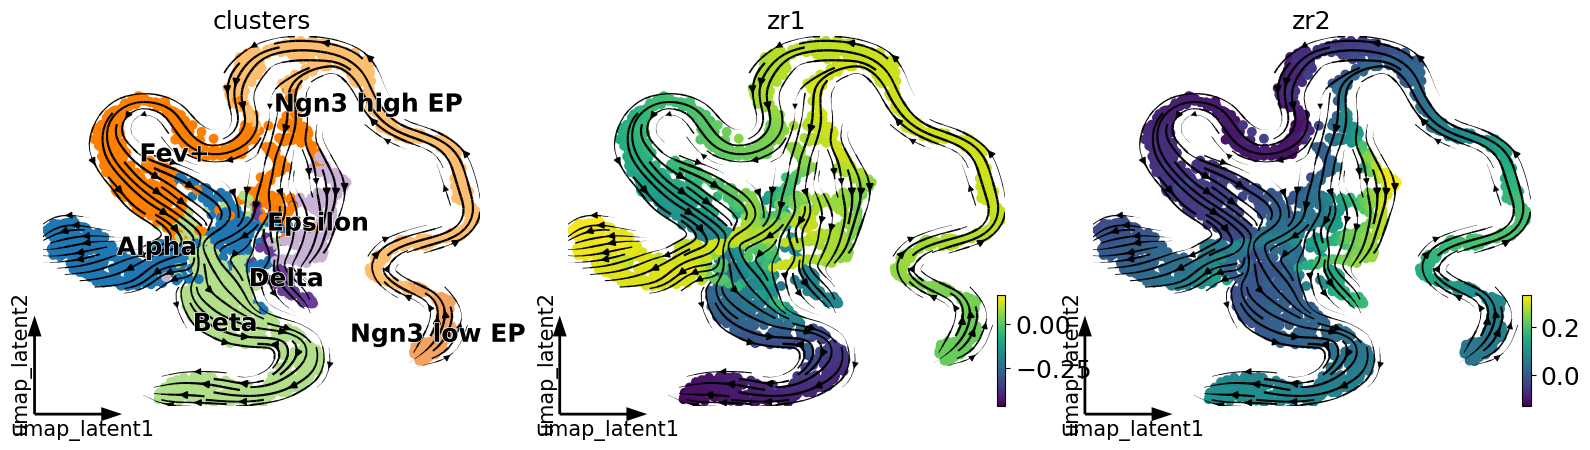

In [37]:
latent_adata.obsm['X_umap_latent'] = umap.transform(latent_adata.X)
latent_adata.obs['zr1'] = latent_adata.obsm['zr'][:,0]
latent_adata.obs['zr2'] = latent_adata.obsm['zr'][:,1]
scv.pp.neighbors(latent_adata, use_rep='X', n_neighbors=30)
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity')
scv.pl.velocity_embedding_stream(latent_adata, vkey='spliced_velocity', 
                                 basis='umap_latent', color=['clusters','zr1', 'zr2'], alpha=1, size=200,
                                frameon='artist', cutoff_perc=0)

Renamed 'zr' to convention 'X_zr' (adata.obsm).
Renamed 'zr' to convention 'X_zr' (adata.obsm).
Renamed 'zr' to convention 'X_zr' (adata.obsm).
Renamed 'zr' to convention 'X_zr' (adata.obsm).


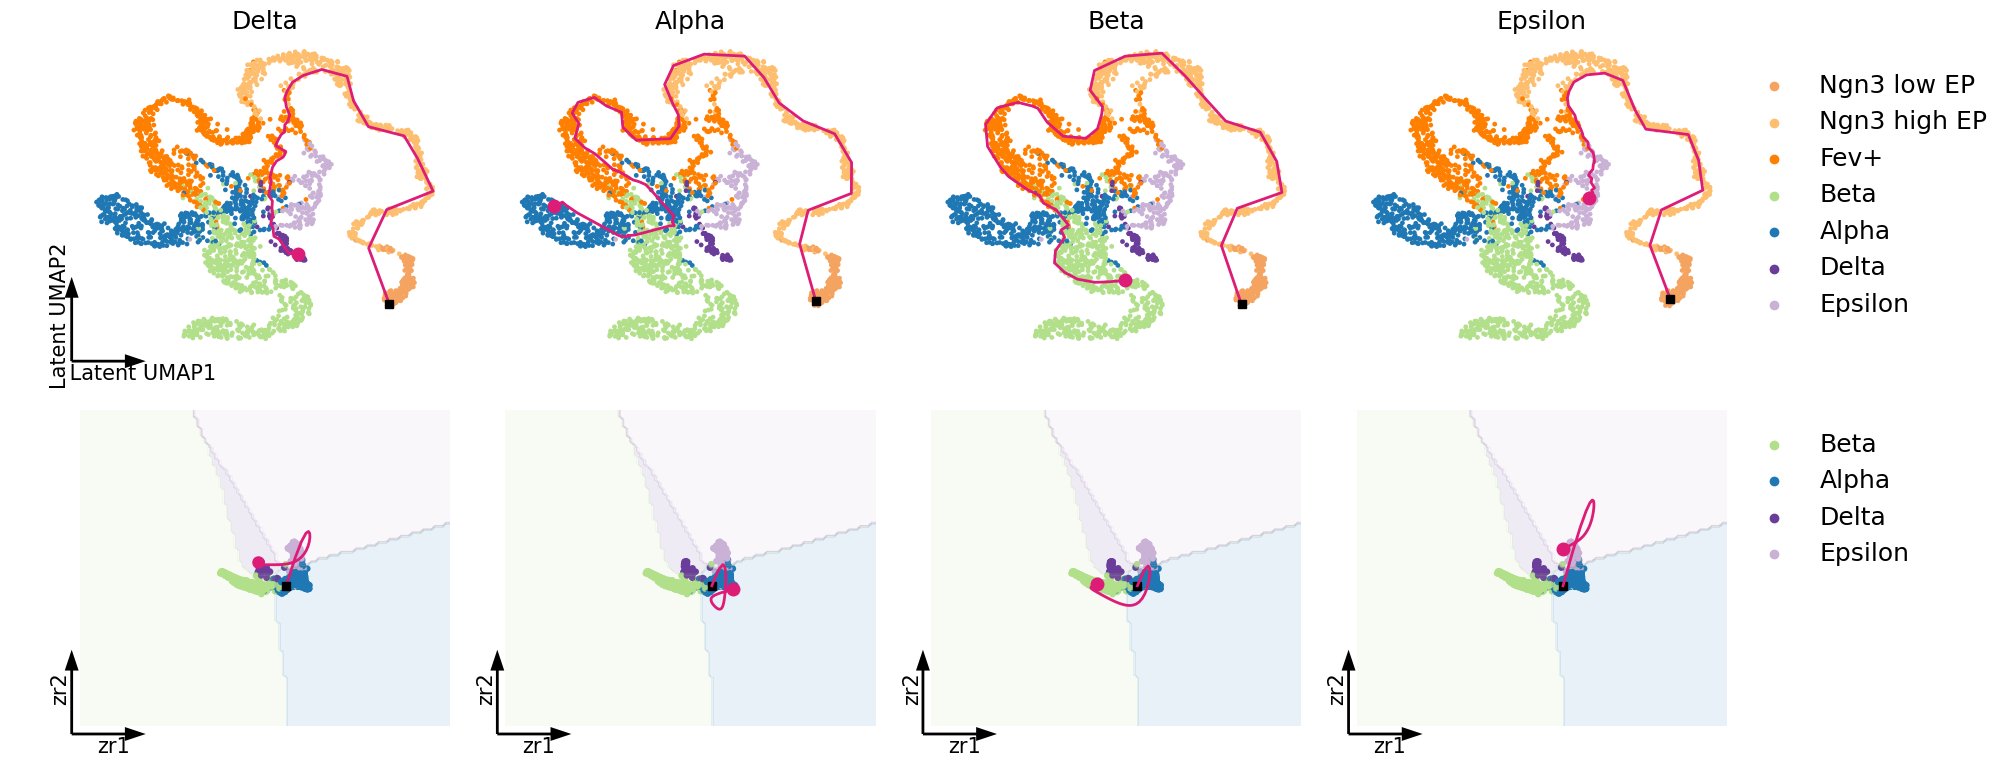

In [38]:
cells = [4, 1833, 52, 229]

from sklearn.inspection import DecisionBoundaryDisplay
color = '#dd1c77'

import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['#1f78b4', '#b2df8a', '#6a3d9a', '#cab2d6'])


fig,ax=plt.subplots(2, 4, figsize=(20,8))
ax=ax.flatten()


color = '#dd1c77'

latent_adata.obsm['X_umap'] = latent_adata.obsm['X_umap_latent']

z_traj_pca = umap.transform(z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],:model.latent].detach().cpu().numpy())
ax[0].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[0].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[0].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[0], color='clusters', frameon='artist',
           xlabel='         Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Delta',
           legend_loc='none', fontsize=18)


z_traj_pca = umap.transform(z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],:model.latent].detach().cpu().numpy())
ax[1].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[1].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[1].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[1], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Alpha',
           legend_loc='none', fontsize=18)


z_traj_pca = umap.transform(z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],:model.latent].detach().cpu().numpy())
ax[2].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[2].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[2].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[2], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Beta',
           legend_loc='none', fontsize=18)


z_traj_pca = umap.transform(z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],:model.latent].detach().cpu().numpy())
ax[3].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[3].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)
ax[3].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)

scv.pl.umap(latent_adata, ax=ax[3], color='clusters',
           xlabel='Latent UMAP1', ylabel='Latent UMAP2', show=False, title='Epsilon',
           legend_loc='right', fontsize=18, legend_fontsize=18)






disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[4]
)
disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[5]
)
disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[6]
)
disp = DecisionBoundaryDisplay.from_estimator(
clf, X, response_method="predict", cmap=cmap,
alpha=0.1,ax=ax[7]
)
    

z_traj_pca = (z_traj[cells[0],times[cells[0],:,0]<=latent_adata.obs['latent_time'][cells[0]],2*model.latent:].detach().cpu().numpy())
ax[4].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[4].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=8)

for i in range(4,4+4):
    ax[i].plot([z_traj_pca[0,0]], [z_traj_pca[0,1]], color='k', linewidth=2, marker='s', markersize=6)


scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])], 
               'zr', ax=ax[4], 
               color='clusters', frameon='artist',
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False,
              legend_loc='none')

z_traj_pca = (z_traj[cells[1],times[cells[1],:,0]<=latent_adata.obs['latent_time'][cells[1]],2*model.latent:].detach().cpu().numpy())
ax[5].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[5].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)

scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])], 
               'zr', ax=ax[5], 
               color='clusters', frameon='artist',
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False,
              legend_loc='none')

z_traj_pca = (z_traj[cells[2],times[cells[2],:,0]<=latent_adata.obs['latent_time'][cells[2]],2*model.latent:].detach().cpu().numpy())
ax[6].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[6].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)

scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])], 
               'zr', ax=ax[6], 
               color='clusters', frameon='artist',
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False,
              legend_loc='none')

z_traj_pca = (z_traj[cells[3],times[cells[3],:,0]<=latent_adata.obs['latent_time'][cells[3]],2*model.latent:].detach().cpu().numpy())
ax[7].plot(z_traj_pca[:,0], z_traj_pca[:,1], color=color, linewidth=2)
ax[7].plot([z_traj_pca[-1,0]], [z_traj_pca[-1,1]], color=color, linewidth=2, marker='o', markersize=9)

scv.pl.scatter(latent_adata[latent_adata.obs['clusters'].isin(['Alpha', 'Beta', 'Epsilon', 'Delta'])],
               'zr', ax=ax[7], 
               color='clusters', frameon='artist',legend_fontsize=18,
           xlabel='zr1', ylabel='zr2', fontsize=18, title='', show=False)
plt.tight_layout()
#plt.savefig('../figures/pancreas_both_dynamics_May8.png', dpi=500)
plt.show()

In [39]:
import torch as th
with th.no_grad():
    xhat =  model.decoder_s(z_traj[...,:model.latent].cuda()).cpu().numpy()
    xhat_delta_traj = xhat[delta_cells]
    xhat_beta_traj = xhat[beta_cells]
    xhat_alpha_traj = xhat[alpha_cells]
    xhat_epsilon_traj = xhat[epsilon_cells]

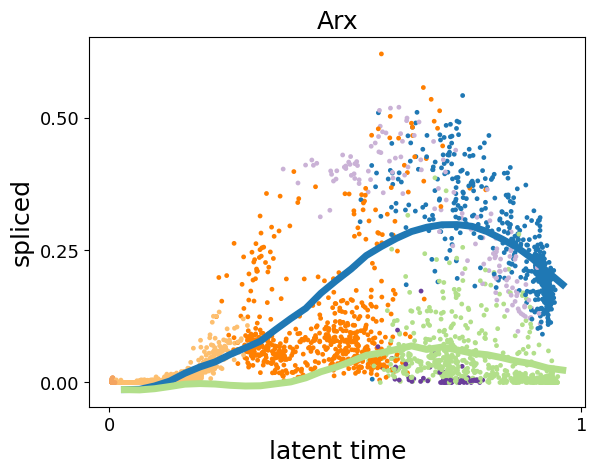

In [40]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

alpha_mean, bin_edges_alpha, _ = binned_statistic(times[alpha_cells,:,0].numpy().flatten(), 
                                        xhat_alpha_traj[:,:,np.where(adata.var.index.values=='Arx')[0]].flatten(),
                                        statistic=np.median, bins=30)
    
beta_mean, bin_edges_beta, _ = binned_statistic(times[beta_cells,:,0].numpy().flatten(), 
                                        xhat_beta_traj[:,:,np.where(adata.var.index.values=='Arx')[0]].flatten(),
                                        statistic=np.median, bins=30)
    
delta_mean, bin_edges_delta, _ = binned_statistic(times[delta_cells,:,0].numpy().flatten(), 
                                        xhat_delta_traj[:,:,np.where(adata.var.index.values=='Arx')[0]].flatten(),
                                        statistic=np.median, bins=30)

plt.plot(bin_edges_alpha[1:], alpha_mean,
        color=adata.uns['clusters_colors'][-3], zorder=100, linewidth=5)
plt.plot(bin_edges_beta[1:], beta_mean,
        color=adata.uns['clusters_colors'][-4], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Arx', color='clusters',ax=ax,show=False, layer='spliced',
              fontsize=18)
#plt.ylim(0,)
#plt.savefig('figures/alpha_beta_arx_May8.pdf')
plt.show()

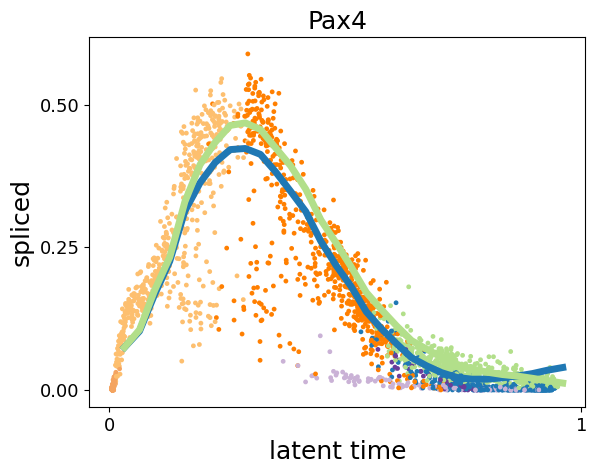

In [41]:
from scipy.stats import binned_statistic

fig,ax=plt.subplots()

alpha_mean, bin_edges_alpha, _ = binned_statistic(times[alpha_cells,:,0].numpy().flatten(), 
      xhat_alpha_traj[:,:,np.where(adata.var.index.values=='Pax4')[0]].flatten(),
      statistic=np.median, bins=30)

beta_mean, bin_edges_beta, _ = binned_statistic(times[beta_cells,:,0].numpy().flatten(), 
        xhat_beta_traj[:,:,np.where(adata.var.index.values=='Pax4')[0]].flatten(),
        statistic=np.median, bins=30)

delta_mean, bin_edges_delta, _ = binned_statistic(times[delta_cells,:,0].numpy().flatten(), 
           xhat_delta_traj[:,:,np.where(adata.var.index.values=='Pax4')[0]].flatten(),
           statistic=np.median, bins=30)

plt.plot(bin_edges_alpha[1:], alpha_mean,
        color=adata.uns['clusters_colors'][-3], zorder=100, linewidth=5)
plt.plot(bin_edges_beta[1:], beta_mean,
        color=adata.uns['clusters_colors'][-4], zorder=100,linewidth=5)

scv.pl.scatter(adata, x='latent_time', y='Pax4', color='clusters',ax=ax,show=False, layer='spliced',
              fontsize=18)
#plt.savefig('figures/alpha_beta_pax4_May8.pdf')
#plt.ylim(0,)
plt.show()

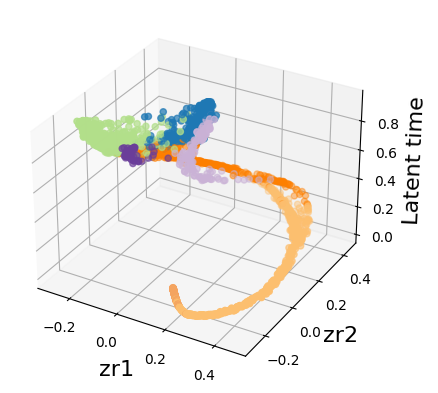

In [67]:
#%matplotlib notebook
from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')


clusters = np.array(['Ngn3 low EP', 'Ngn3 high EP', 'Fev+', 'Beta', 'Alpha', 'Delta', 'Epsilon'])
colors = latent_adata.uns['clusters_colors']

cell_color = []
for i in range(latent_adata.shape[0]):
    cell_color.append(colors[np.where(clusters == latent_adata.obs.clusters[i])[0][0]])


# Data for a three-dimensional line
xdata = latent_adata.obs.latent_time
ydata = latent_adata.obsm['zr'][:,0]
zdata = latent_adata.obsm['zr'][:,1]


ax.scatter3D(zdata, ydata, xdata, color = cell_color);

ax.set_zlabel('Latent time',fontsize=16)
ax.set_ylabel('zr2',fontsize=16)
ax.set_xlabel('zr1',fontsize=16)

#ax.

plt.draw()
plt.show()

In [32]:
plt.tight_layout()
plt.savefig('figures/3d_plot.pdf')